In [1]:
from IPython.core.display import HTML
import numpy as np
import sys
sys.path.append('/public4/home/sc57082/local')
sys.path.append('/public4/home/sc57082/local/pygadgetreader')

import readgadget as rg 
import glio 
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

HTML("""
<style>
    .CodeMirror, .output_subarea, .input{
        font-size: 20px;
    }
</style>
""")

In [2]:
petar_path = '/public4/home/sc57082/GC/petar_data/data.1000.s'

with open(petar_path, 'r') as file:
    # 逐行读取文件
    first_row = file.readline().strip().split()
first_row = np.array(first_row, dtype=float)
data = np.loadtxt(petar_path, skiprows=1)

unit = 0.9777922

m = data[:,0]
pos = data[:,1:4]/1e3
vel = data[:,4:]*unit


In [3]:
def cartesian_to_spherical(pos,vel):
    x = pos[:,0]
    y = pos[:,1]
    z = pos[:,2]
    vx = vel[:,0]
    vy = vel[:,1]
    vz = vel[:,2]
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z / r)
    phi = np.arctan2(y, x)
    vr = (x * vx + y * vy + z * vz) / r

    return  vr
def cent_h(X):


    # 构建 KD 树
    tree = cKDTree(X)  

    # 为每个点查询最近的30个邻居点
    dist, ind = tree.query(X, k=50)  

    # 计算局部密度
    epsilon = 1e-5
    rho = 1 / (dist + epsilon).sum(axis=1)

    # 密度最大值点的索引
    densest_idx = np.argmax(rho)

    return X[densest_idx]

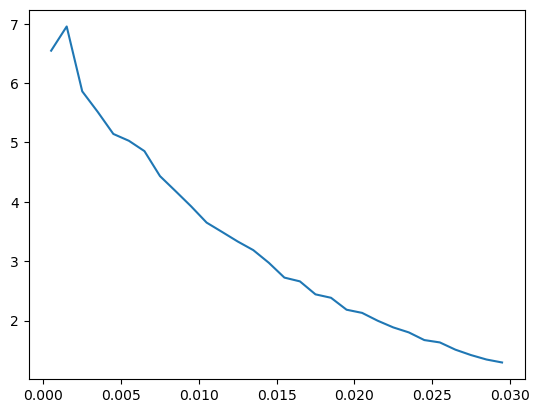

In [5]:
r = ((pos**2).sum(-1))**0.5
n=30
sigma_r = np.zeros(n)
R = np.zeros(n)
Vr = np.zeros(n)

for i in range(n):
    j = i/1e3
    vr = cartesian_to_spherical(pos[(r <= j+1/1e3)&(r>j), :],vel[(r <= j+1/1e3)&(r>j), :])
    sigma_r[i] = np.var(vr)
    Vr[i] = np.mean(vr)
    R[i] = (i+0.5)/1e3
plt.plot(R,sigma_r)



(209998,) (209998,)


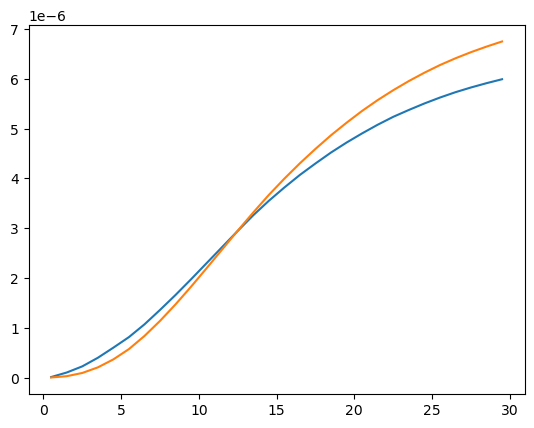

In [6]:
M = np.zeros(n)
M_ic = np.zeros(n)
ic_m = np.full(m.shape, 0.45)/1e10
print(ic_m.shape,m.shape)
for i in range(n):
    j = i/1e3
    M[i] = m[(r <= j+1/1e3)].sum(-1)/1e10
    M_ic[i] = ic_m[(r <= j+1/1e3)].sum(-1)
    R[i] = (i+0.5)

plt.plot(R,M)
plt.plot(R,M_ic)

Returning BULGE Positions
Returning BULGE Velocities
Returning BULGE Mass
[4.0145736e-07 4.0145736e-07 4.0145736e-07 ... 4.0145736e-07 4.0145736e-07
 4.0145736e-07]


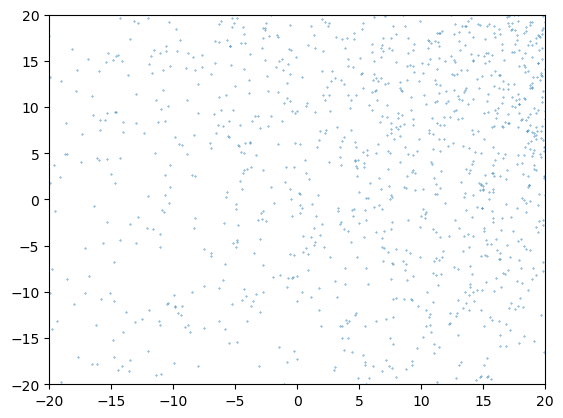

[49.31358  -5.953091 26.019331]


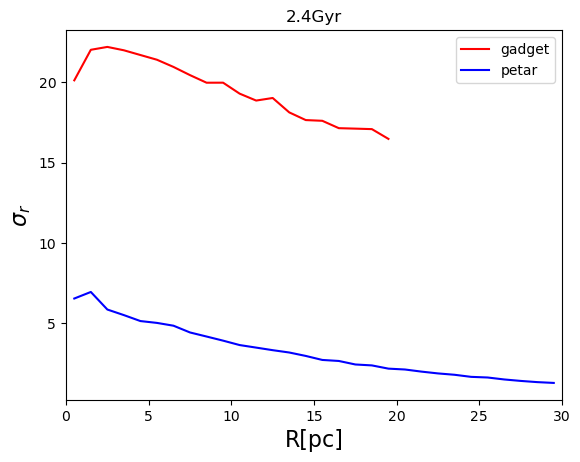

In [14]:
runpath = '/public4/home/sc57082/Output/halo_disk/rot_bulge/'
i = 0


snapfname = runpath + 'snapshot_' + str(i).zfill(3) 

phalo = rg.readsnap(snapfname, 'pos', 'bulge')
vhalo = rg.readsnap(snapfname, 'vel', 'bulge')
mhalo = rg.readsnap(snapfname, 'mass', 'bulge')

print(mhalo)
plt.scatter(phalo[:,0],phalo[:,2],s=0.1)

plt.xlim(-20,20)
plt.ylim(-20,20)
plt.show()

cent_dm = cent_h(phalo)
print (cent_dm)

pos_dm = phalo - cent_dm
r_cent = ((pos_dm**2).sum(-1))**0.5
vcent =  np.mean(vhalo[r_cent <= 0.01, :], axis=0)
vel_dm = vhalo - vcent
n=20
sigma_r_gadget = np.zeros(n)
R_gadget = np.zeros(n)

for i in range(n):
    j = i/1
    vr = cartesian_to_spherical(pos_dm[(r_cent <= j+1)&(r_cent>j), :],
                                vel_dm[(r_cent <= j+1)&(r_cent>j), :])
    sigma_r_gadget[i] = np.std(vr)
    R_gadget[i] = (i+0.5)
plt.plot(R_gadget,sigma_r_gadget,c='red',label=
        'gadget')
plt.plot(R,sigma_r,c='blue',label='petar')
plt.xlabel('R[pc]',fontsize=16)
plt.ylabel('$\sigma_r$',fontsize=16)
plt.title('2.4Gyr')
plt.legend()
plt.xlim(0,30)
#plt.ylim(0,12)
plt.show()



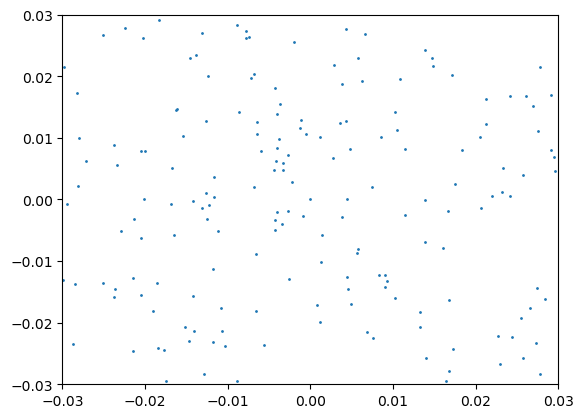

In [12]:
plt.scatter(pos_dm[:,0],pos_dm[:,2],s=1)

plt.xlim(-0.03,0.03)
plt.ylim(-0.03,0.03)
plt.show()